## Importing Necessary Libraries And The Data

In [73]:
## importing necessary libraries
import numpy as np
from matplotlib import pyplot as plt
from cs231n.data_utils import load_CIFAR10
import time
import random

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'


cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

x_train, y_train, x_test, y_test = load_CIFAR10(cifar10_dir)

'''
If you don't have the CIFAR-10 dataset batch files, you can use tenseflow to load the dataset. For that comment the above two
two lines of code and uncomment below code. NOTE: You must have tensorflow installed.

import tensorflow as tf
cifar = tf.keras.datasets.cifar10
(x_train, y_train), (x_test, y_test) = cifar.load_data()

'''

print("")
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)


(50000, 32, 32, 3)
(50000,)
(10000, 32, 32, 3)
(10000,)


## Visualizing The CIFAR10 Data

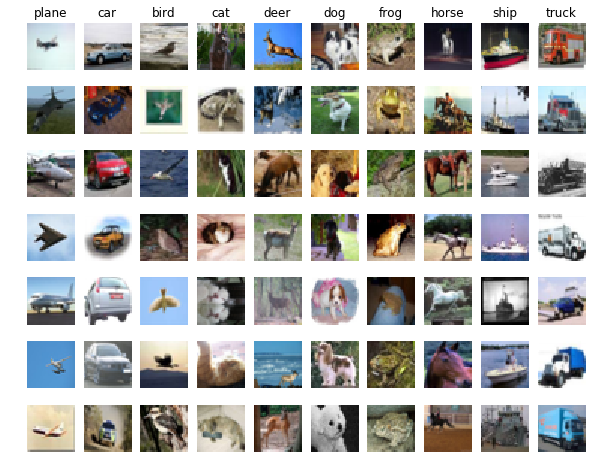

In [74]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(x_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

## Splitting The Data

### Splitting the data into training, test, validation and dev sets.

In [75]:
## decding number of examples to allot to each set
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

## validation set
mask = list(range(num_training, num_training + num_validation))
x_val, y_val = x_train[mask], y_train[mask]

## training data
mask = list(range(num_training))
x_train, y_train = x_train[mask], y_train[mask]

## test data
mask = list(range(num_test))
x_test, y_test = x_test[mask], y_test[mask]

## dev data 
## dev data should be subset of training data, its used to make processing faster
mask = np.random.choice(num_training, num_dev, replace = False)
x_dev, y_dev = x_train[mask], y_train[mask]


## printing the dimensions of all the sets and their labels
print("Training Data Shape : ",x_train.shape)
print("Training Labels Shape : ",y_train.shape)
print("Test Data Shape : ",x_test.shape)
print("Test Labels Shape : ",y_test.shape)
print("Validation Data Shape : ",x_val.shape)
print("Validation Labels Shape : ",y_val.shape)
print("Dev Data Shape : ",x_dev.shape)
print("Dev Labels Shape : ",y_dev.shape)

Training Data Shape :  (49000, 32, 32, 3)
Training Labels Shape :  (49000,)
Test Data Shape :  (1000, 32, 32, 3)
Test Labels Shape :  (1000,)
Validation Data Shape :  (1000, 32, 32, 3)
Validation Labels Shape :  (1000,)
Dev Data Shape :  (500, 32, 32, 3)
Dev Labels Shape :  (500,)


## Preprocessing Images
### Reshaping Images into Rows

In [76]:
## reshaping the images into rows
x_train = x_train.reshape(x_train.shape[0],-1)
x_test = x_test.reshape(x_test.shape[0],-1)
x_dev = x_dev.reshape(x_dev.shape[0],-1)
x_val = x_val.reshape(x_val.shape[0],-1)

## as a sanity check printing the shape of the data
print('Training Data Shape : ',x_train.shape)
print('Test Data Shape : ',x_test.shape)
print('Validation Data Shape : ',x_val.shape)
print('Dev Data Shape : ',x_dev.shape)

Training Data Shape :  (49000, 3072)
Test Data Shape :  (1000, 3072)
Validation Data Shape :  (1000, 3072)
Dev Data Shape :  (500, 3072)


## Computing The Mean Image
## So that we can later subtract it from all our data so to normalize it

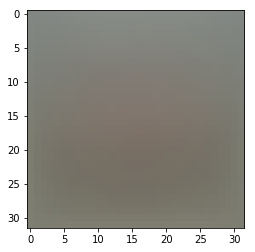

In [77]:
## computing the mean image
mean_image = np.mean(x_train, axis = 0)

## printing our mean image
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape(32,32,3).astype('uint8'))
plt.show()

## Subtracting the mean image from all of our data

In [78]:
## prinitng a sample before and after image after subtracting mean image

## subtracting mean image from all of our sets
x_train -= mean_image
x_test -= mean_image
x_dev -= mean_image
x_val -= mean_image

## The Bias Trick
### Using The Bias Trick And Appending an Extra Dimension to The Weight Matrix

In [79]:
## third: append the bias dimension of ones (i.e. bias trick) so that our SVM
## only has to worry about optimizing a single weight matrix w.

x_train = np.hstack([x_train, np.ones((x_train.shape[0],1))])
x_test = np.hstack([x_test, np.ones((x_test.shape[0],1))])
x_val = np.hstack([x_val, np.ones((x_val.shape[0],1))])
x_dev = np.hstack([x_dev, np.ones((x_dev.shape[0],1))])

## printing shapes again as a sanity check
print(x_train.shape," ",x_test.shape," ",x_val.shape," ",x_dev.shape," ")

(49000, 3073)   (1000, 3073)   (1000, 3073)   (500, 3073)  


## SVM Classifier

### Implementing The Naive Code For Calculating SVM Loss and Gradients

In [80]:
def svm_loss_naive(W, x, y, reg):
    
    ## initial loss
    loss = 0.0
    ## initialize gradient as vector of zero
    dW = np.zeros(W.shape)
    
    ## number of classes
    num_classes = W.shape[1]
    
    ## number of training examples
    num_train = x.shape[0]
    
    ## defining SVM margin -- delta
    delta = 1.0
    
    ## ------------------------------ coding the naive loss and grad functions -------------------------------------
    
    for i in range(num_train):
        
        ## x[i] will have shape of (1, 3073) and W will have shape of (3073, 10) and their dot will give a one-hot array (1,10)
        scores = np.dot(x[i], W)
        
        ## getting correct class's score
        correct_class_score = scores[y[i]]
        
        ## number of classes contributing loss
        loss_contributors_count = 0
        
        for j in range(num_classes):
            
            ## if correct class
            if j == y[i]:
                continue
            
            margin = scores[j] - correct_class_score + delta ## delta = 1
            if margin > 0:
                ## adding loss
                loss = loss + margin 
                ## counting contributor terms to the loss function
                loss_contributors_count += 1
                
                ## gradient for incorrect class
                dW[:, j] += x[i]
                
        ## correct class gradient part
        dW[:, y[i]] += (-1) * loss_contributors_count * (x[i])
        
    ## to calculate average loss and gradient over all training examples 
    loss = loss/num_train
    dW = dW/num_train
        
    ## Add regularization loss to the bias
    loss += reg* np.sum(W*W)
        
    dW += (2 * reg * W)
        
    return loss, dW
        
## -------------------------------------------- function ends here ---------------------------------------------------

## Generating a random weight matrix of small numbers
## 785 for image size and 10 because of number of classes
W = np.random.randn(3073,10) * 0.0001

## storing initialized weight into a variable so that I can use same weights for any other computations initially
## which will help me gain a better insight of the problem.
initial_W = W

## calling the svm_loss_vectorized function
loss, grad = svm_loss_naive(W, x_dev, y_dev, reg = 0.000005)
print(loss)

9.166533828806983


## Gradient Checking
### Computing Numerical Gradient And Checking It With The Above Analytically Computed Gradient

In [81]:
from random import randrange

## this function checks numerical and analytic gradients for a function f and parameter x .... [ f'(x) numerically ]
def grad_check(f, x, analytic_grad, num_checks = 10, h = 1e-5):
    
    for _ in range(num_checks):
        ## we'll pick random number of rows and columns in x
        ix = tuple([randrange(m) for m in x.shape])
    
        ## old value stored safely in a 'oldval' variable
        oldval = x[ix]
        ## x[ix] is increased by h
        x[ix] = oldval + h 
        
        ## increment was done only on x[ix] but f calculation will be of f(x) in which h has already been added
        fxph = f(x) 
        
        ## same process as above for decrement of h from x[ix]
        
        x[ix] = oldval - h
        ## calculatiing f(x) where x --> x[ix] = oldval- h
        fxmh = f(x) 
        
        ## changing value of x[ix] back to orignal
        x[ix] = oldval
        
        grad_numerical = (fxph - fxmh) / (2 * h)

        
        ## analytic gradient
        grad_analytic = analytic_grad[ix]
        
        ## relative error
        rel_error = abs( grad_numerical - grad_analytic ) / ( abs(grad_numerical) + abs(grad_analytic) )
        
        print('Numerical : {} Analytic : {} , Relative : {} '.format(grad_numerical, grad_analytic, rel_error))
        

## calculating analytic gradient and cost using svm_loss_naive() function        
loss, grad = svm_loss_naive(W, x_dev, y_dev, 1e2)

## the function f which returns 'svm loss' for a particular 'w'
f = lambda w : svm_loss_naive(w, x_dev, y_dev, 1e2)[0] 

## calling the above grad_check() function
grad_numerical = grad_check(f, W, grad)

Numerical : 9.963821457414923 Analytic : 9.963821457677733 , Relative : 1.3188223973713537e-11 
Numerical : 6.531970977707856 Analytic : 6.531970977755343 , Relative : 3.6349257652211836e-12 
Numerical : -12.544425953375791 Analytic : -12.544425952878829 , Relative : 1.9808099351525887e-11 
Numerical : 11.701007416675678 Analytic : 11.701007416992736 , Relative : 1.3548336833575582e-11 
Numerical : -27.627838571753212 Analytic : -27.627838572159668 , Relative : 7.355901417910779e-12 
Numerical : 8.306833280080639 Analytic : 8.306833280430043 , Relative : 2.10311227787619e-11 
Numerical : -48.596956195723344 Analytic : -48.612959665528464 , Relative : 0.00016462795655499185 
Numerical : 25.655508039079674 Analytic : 25.65550803920607 , Relative : 2.463309133419682e-12 
Numerical : 3.2154924205052278 Analytic : 3.215492419973687 , Relative : 8.265306209021987e-11 
Numerical : 15.01743583638415 Analytic : 15.0174358361316 , Relative : 8.408558680780206e-12 



### Implementing The Vectorized Code For Calculating SVM Loss and Gradients

In [82]:
def svm_loss_vectorized(W, x, y, reg):
    
    ## initial loss 
    loss = 0.0
    ## initializing weight-gradient dW matrix with all zeros
    dW = np.zeros(W.shape)
    
    ## number of training examples in x
    num_train = x.shape[0]
    ## choosing the value of delta
    delta = 1.0
    
    ## ------------------------------- coding the vectorized loss function ------------------------------------------
    
    ## x is (num_train,3073) and w is (3073,10) and hence score will be (num_train,10)
    ## this means score will have class score for each training example for all classes
    scores = np.dot(x,W)
    
    ## getting correct class scores
    correct_class_scores = scores[list(range(num_train)), y]
    correct_class_scores = correct_class_scores.reshape(num_train, -1)
    
    ## getting the margins for all classes (both correct and incorrect classes)
    margins = np.maximum( 0, scores - correct_class_scores + delta )
    ## making the margins obtained from the correct classes equal to zero.
    margins[list(range(num_train)),y] = 0
    
    ## calculating loss
    loss = np.sum(margins)
    ## getting mean loss
    loss = loss/num_train
    
    ## adding the regularization term to the loss
    loss = loss + (reg * np.sum(W*W))
    
    ## ------------------------------------- coding the vectorized gradient -----------------------------------------
    
    ## shape of 'margins' is (num_train,10) and therefore same will be of x_mask
    x_mask = np.zeros(margins.shape)
    
    ## places where margins is not equal to zero will be 1
    x_mask[margins>0] = 1
    
    ## for each sample counting number of classes where margins>0
    incorrect_samples = np.sum(x_mask, axis=1)
    
    ## making the correct classes for each sample equal to their respective incorrect_counts
    x_mask[np.arange(num_train), y] = -incorrect_samples
    
    ## dW must be equal to W.shape i.e. (3073, 10)
    ## x.transpose is (3073, num_train) and x_mask is (num_train, 10)
    ## Hence, dW will become (3073, 10)
    dW = np.dot(x.transpose(),x_mask)
    
    ## finding the mean weights
    dW = dW / num_train
    ## regularizing the weights
    dW = dW + (2*reg*W)
    
    return loss,dW

## -------------------------------------------- function ends here ---------------------------------------------------

## Generating a random weight matrix of small numbers
## 785 for image size and 10 because of number of classes
W = np.random.randn(3073,10) * 0.0001

## using the initialized value of W
W = initial_W

## calling the svm_loss_vectorized function
loss, grad = svm_loss_vectorized(W, x_dev, y_dev, reg = 0.000005)
print(loss)

9.166533828806957


### Checking the difference b/w Naive And Vectorized Implementations of Loss And Grad Functions

In [83]:
## naive call
tic = time.time()
naive_loss, naive_grad = svm_loss_naive(W, x_dev, y_dev, reg = 0.000005)
toc = time.time()
print('Naive Loss : {} computed in {}\n'.format(naive_loss, toc-tic))

## vectorized call
tic = time.time()
vectorized_loss, vectorized_grad = svm_loss_vectorized(W, x_dev, y_dev, reg = 0.000005)
toc = time.time()
print('Vectorized Loss : {} computed in {}\n'.format(vectorized_loss, toc-tic))

print('Loss Absolute Difference: {}\n'.format(abs(naive_loss - vectorized_loss)))      
      
## loss is a scalar value and hence we can just calculate and print the difference but as gradient is a matrix,
## we will have to calculate frobenius norm to compare them.
grad_diff = np.linalg.norm(naive_grad - vectorized_grad, ord='fro')
print('Gradient Difference: {}\n'.format(grad_diff))

Naive Loss : 9.166533828806983 computed in 0.2741103172302246

Vectorized Loss : 9.166533828806957 computed in 0.008005619049072266

Loss Absolute Difference: 2.6645352591003757e-14

Gradient Difference: 2.337532339030333e-11



## Stochastic Gradient Descent
### Applying Gradient Descent to Optimize The Weights And Hence Train The Network

In [84]:
def train(x, y, learning_rate=1e-3, reg=1e-5, num_iters=100, batch_size=200, verbose =False):
    '''
    Training a Linear Classifier
    
    X --- This is our Input Data of shape (N, D) where N is number of examples and D is dimensions of one example
    Y --- Training Label -- Correct Class for each example of N
    learning_rate --- Learning Rate for optimization
    Reg --- the regularization constant lambda --- 1e-5
    num_iters --- number of epochs
    batch_size --- batch size for mini batch gradient descent
    verbose (False) --- If true print progress
    
    Output:
    
    A list containing loss after each iteration which will be used later for making the cost/iteration graph
    '''
    
    num_train, dim = x.shape
    ## assuming that there will be atleast one example of class (k - 1) when there are k classes from (0) to (k-1) 
    num_classes = np.max(y) + 1
    
    ## initializing W ...  the W initialized above (outside this function) was there to only to run the
    ## svm_loss_vectorized() function for the first time.
    W = 0.001 * np.random.randn(dim, num_classes)
    
    ## Running SGD to optimize the weight matrix W
    
    ## intializing the loss history list which will by returned by this function 
    loss_history = []
        
    for it in range(num_iters):
        ## sampling some random indices
        sample_indices = np.random.choice(np.arange(num_train), batch_size)
        
        ## creating the batches
        x_batch = x[sample_indices]
        y_batch = y[sample_indices]
        
        ## evaluating loss and gradient
        loss,grad = svm_loss_vectorized(W, x_batch, y_batch, reg)
        loss_history.append(loss)
        
        ## chainging the weights
        W = W - learning_rate*grad
        
        ## printing if verbose is true
        if(verbose == True and it%100==0):
            print('Iteration {}/{} : Loss {}'.format(it,num_iters,loss))
            
    return loss_history, W

## calling the train() function
loss_hist, new_W = train(x_train, y_train, learning_rate= 1e-7, reg = 2.5e4, num_iters = 1500, verbose = True)

## making new_W equal to W
W = new_W

Iteration 0/1500 : Loss 800.141000500751
Iteration 100/1500 : Loss 290.5151418866595
Iteration 200/1500 : Loss 109.12644058803573
Iteration 300/1500 : Loss 43.16824663289612
Iteration 400/1500 : Loss 18.81041168044653
Iteration 500/1500 : Loss 10.160462969403047
Iteration 600/1500 : Loss 6.970228154826694
Iteration 700/1500 : Loss 5.8939923006558175
Iteration 800/1500 : Loss 5.412193702790931
Iteration 900/1500 : Loss 5.286109067185626
Iteration 1000/1500 : Loss 5.387138818607802
Iteration 1100/1500 : Loss 4.809703155861599
Iteration 1200/1500 : Loss 5.599995655636795
Iteration 1300/1500 : Loss 5.1805233829069275
Iteration 1400/1500 : Loss 5.035077167430461


## Plotting The Loss History
### i.e. Plotting How Loss Changed With Number of Iterations

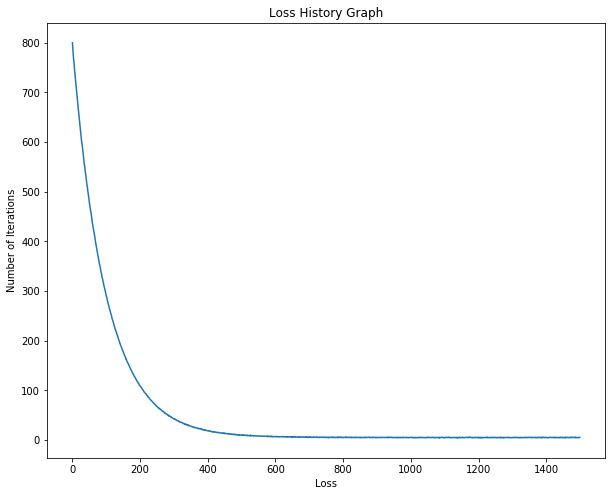

In [85]:
## plotting the graph
plt.plot(loss_hist)
plt.xlabel('Loss')
plt.ylabel('Number of Iterations')
plt.title('Loss History Graph')
plt.show()

## Predicting on Training And Validation Set

In [86]:
## making a function to return predictions using the trained weights

def predict(x):
    
    ## y_pred must have a shape of (N,1) where N is number of examples in x
    y_pred = np.zeros(x.shape[1])
    
    ## currently y_pred has a shape of (N,C) where C is number of classes in x i.e. this is a collection of 1 hot arrays
    y_pred = np.dot(x,W)
    
    ## converting from 1 hot array into 1 dimensional array  i.e. in a label vector
    y_pred = np.argmax(y_pred, axis = 1)
    
    return y_pred


## predictions on the training set

y_train_pred = predict(x_train)
## calculating training accuracy
train_accuracy = np.mean(y_train == y_train_pred)
print("Training Accuracy : {}\n\n".format(train_accuracy))


## predictions on the validation set

y_val_pred = predict(x_val)
## calculating training accuracy
val_accuracy = np.mean(y_val == y_val_pred)
print("Validation Accuracy : {}\n\n".format(val_accuracy))

Training Accuracy : 0.3703469387755102


Validation Accuracy : 0.384




## Tuning The Hyperparameters
### Using the validation set to experiment with different values of learning_rate and regularization parameter 

In [87]:
learning_rates = [1e-8, 1e-7, 2e-7]
regularization_strengths = [2.5e4, 5e4]

results = {}
best_val = -1


for lr in learning_rates:
    for reg in regularization_strengths:
        
        loss_hist, W = train(x_train, y_train, learning_rate = lr, reg= reg, num_iters=1500)
        
        y_train_pred = predict(x_train)
        acc_train = np.mean(y_train == y_train_pred)
        
        y_val_pred = predict(x_val)
        acc_val = np.mean(y_val == y_val_pred)
        
        results[(lr, reg)] = (acc_train, acc_val)
        
        if acc_val > best_val:
            best_val = acc_val

for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('\n\nBest Validation Accuracy Achieved During Cross-Validation: %f' % best_val)

lr 1.000000e-08 reg 2.500000e+04 train accuracy: 0.254898 val accuracy: 0.247000
lr 1.000000e-08 reg 5.000000e+04 train accuracy: 0.290020 val accuracy: 0.301000
lr 1.000000e-07 reg 2.500000e+04 train accuracy: 0.369510 val accuracy: 0.380000
lr 1.000000e-07 reg 5.000000e+04 train accuracy: 0.360694 val accuracy: 0.373000
lr 2.000000e-07 reg 2.500000e+04 train accuracy: 0.358816 val accuracy: 0.355000
lr 2.000000e-07 reg 5.000000e+04 train accuracy: 0.346163 val accuracy: 0.366000


Best Validation Accuracy Achieved During Cross-Validation: 0.380000


## Training the model on best hyperparameters

In [88]:
loss_history, W = train(x_train, y_train, learning_rate = 1e-7, reg= 2.5e4, num_iters=1500)

## Printing Templates Derived After Training Weights

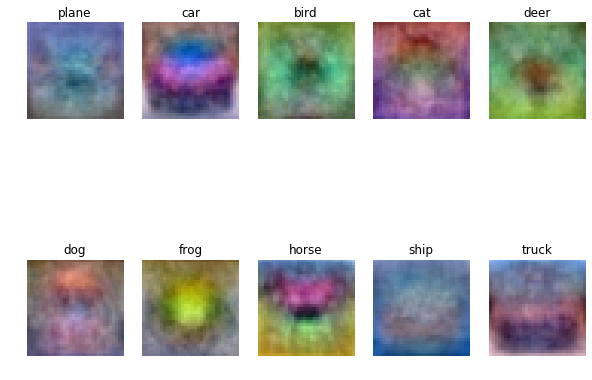

In [101]:
## strip out the bias term
w = W[:-1, :]
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)

## classes list
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
## number of classes
num_classes = len(classes)

for i in range(num_classes):
    plt.subplot(2, 5, i+1)
    
    ## rescaling the weights to be between 0 and 255
    wimg = 255*(w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])